In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Input files
INPUT_DIR = "./DATA/PROCESSED"
INPUT_FILE_ADDITIONAL_PREPEND = ""
INPUT_FILE_DATA_PKL = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + 'full_dataframe.pkl'
INPUT_FILE_OUTLIERS_PKL = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + '95q_outliers_df.pkl'
INPUT_FILE_TRAIN_TS = 'POT_47N_2.5W_' + INPUT_FILE_ADDITIONAL_PREPEND + 'np_train_data.npz'

In [4]:
df_wo_nan = pd.read_pickle(os.path.join(INPUT_DIR, INPUT_FILE_DATA_PKL))
outliers_dataframe = pd.read_pickle(os.path.join(INPUT_DIR, INPUT_FILE_OUTLIERS_PKL))
train_data = np.load(os.path.join(INPUT_DIR, INPUT_FILE_TRAIN_TS), allow_pickle=True)
print(f"Full dataset contains {df_wo_nan.shape[0]} observation points")
print(f"Outliers dataset contains {outliers_dataframe.shape[0]} observation points")
print(f"Train dataset contains {train_data['train_data'].shape} values")
print(f"Windows dataset contains {train_data['windows'].shape} values")
print(f"Timeseries dataset contains {train_data['timeseries'].shape} values")

Full dataset contains 727560 observation points
Outliers dataset contains 1237 observation points
Train dataset contains (1237, 216, 4) values
Windows dataset contains (1237, 2) values
Timeseries dataset contains (1237,) values


In [5]:
from tslearn.clustering import TimeSeriesKMeans

KM_DTW_MODEL_FILEPATH = "./model_dir/kmeans_dtw.hdf5"
km_dtw = TimeSeriesKMeans.from_hdf5(KM_DTW_MODEL_FILEPATH)
km_dtw_result = km_dtw.labels_

In [6]:
from sklearn.cluster import KMeans
import pickle

KM_CAE_MODEL_FILEPATH = "./model_dir/kmeans_cae_4c.pkl"
KM_ED_MODEL_FILEPATH = "./model_dir/kmeans_ed.pkl"
with open(KM_CAE_MODEL_FILEPATH, 'rb') as f:
    km_cae = pickle.load(f)
    km_cae_result = km_cae.labels_

with open(KM_ED_MODEL_FILEPATH, 'rb') as f:
    km_ed = pickle.load(f)
    km_ed_result = km_ed.labels_

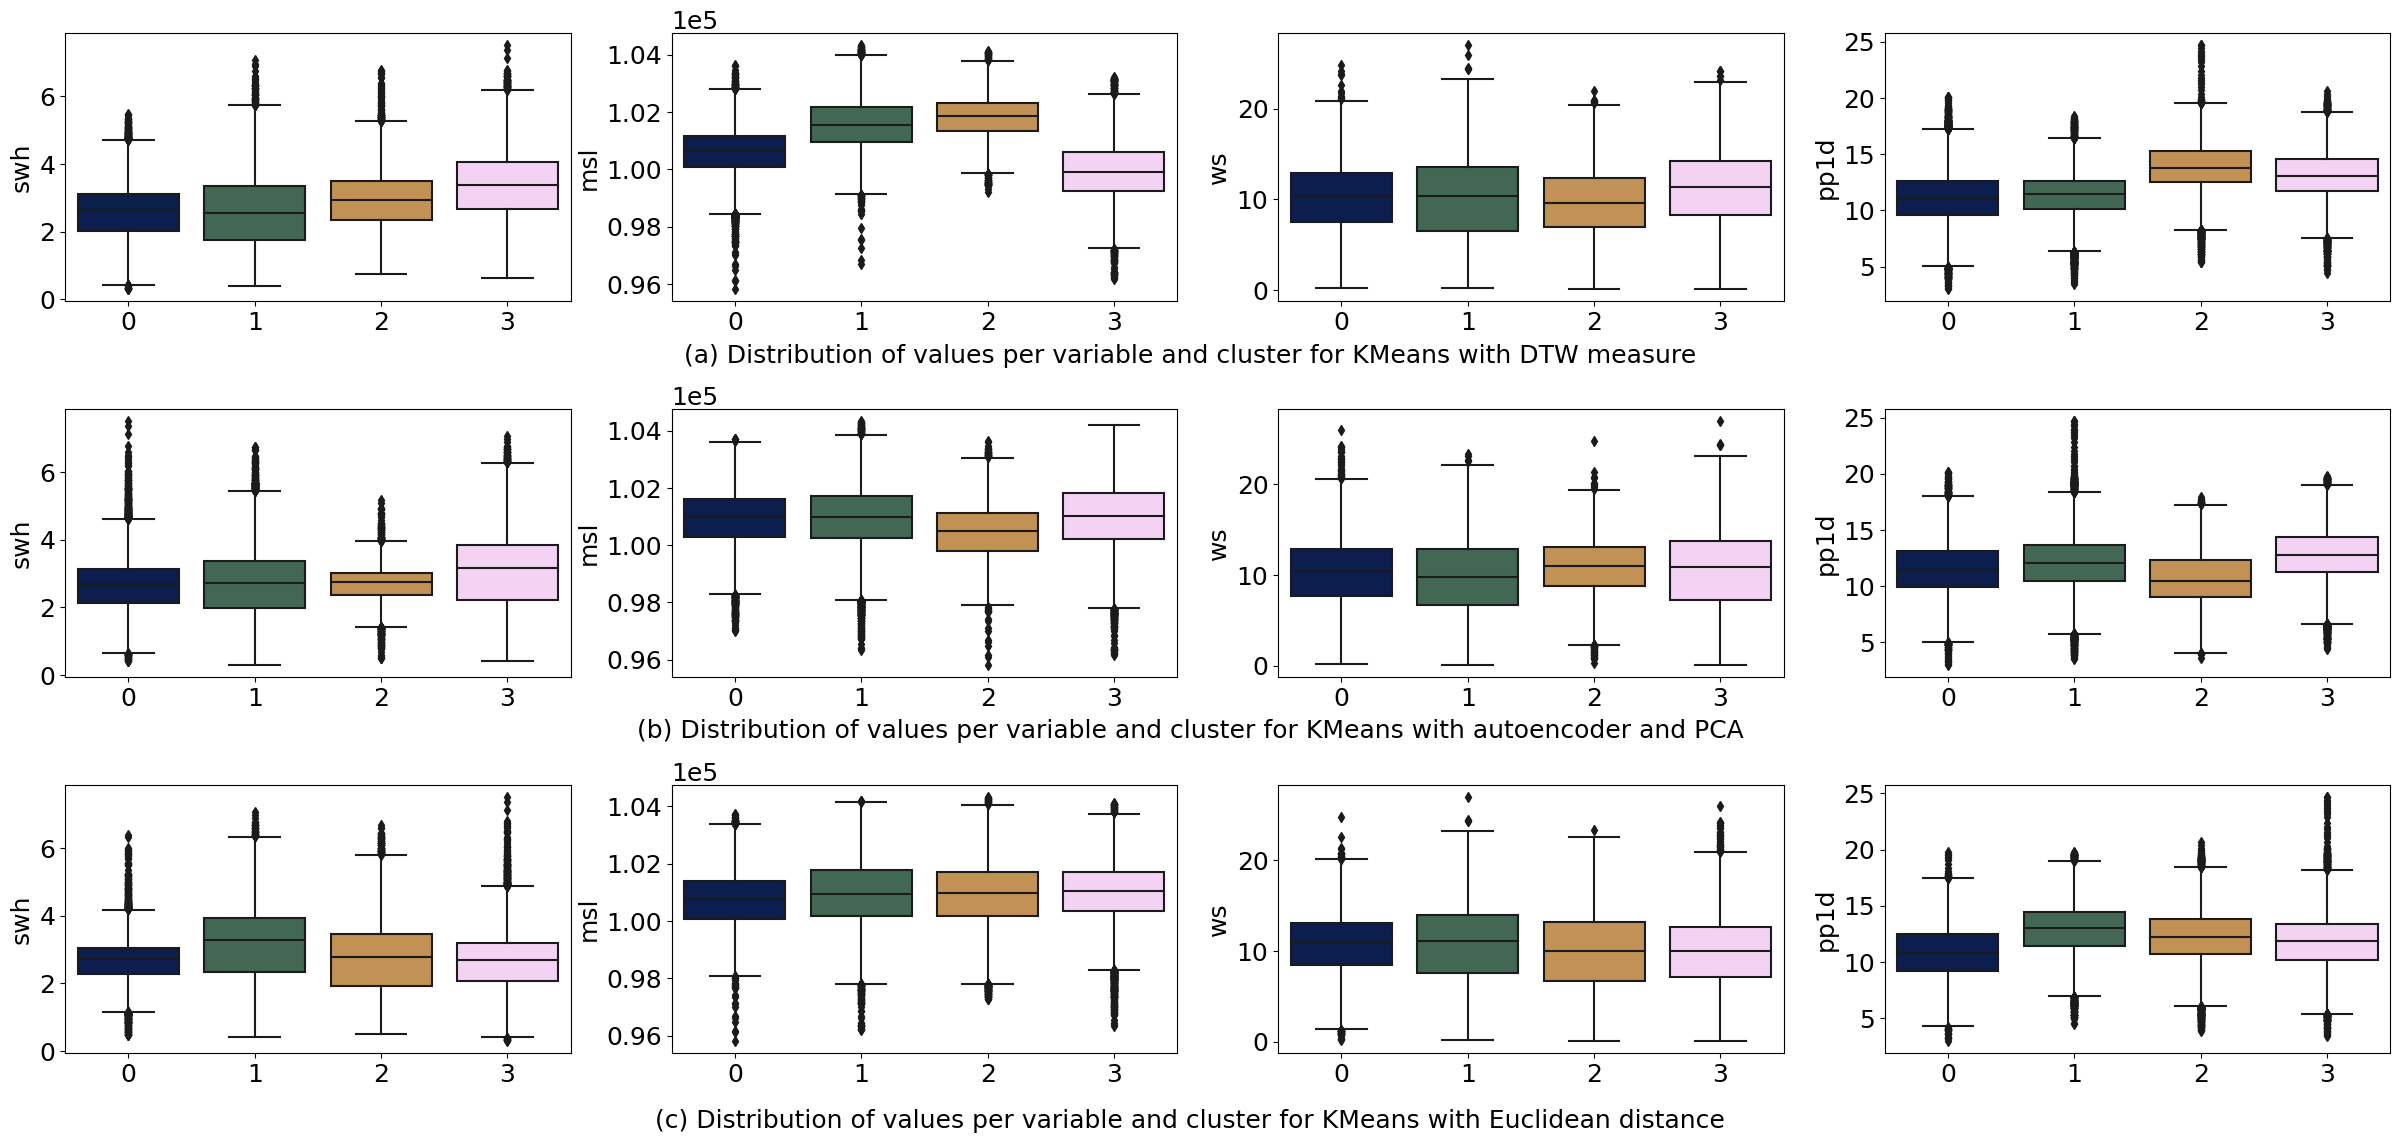

In [8]:
from cmcrameri import cm

raw_timeseries = train_data['raw_timeseries']

data = []
for i, serie in enumerate(raw_timeseries):
    for j, mesure in enumerate(serie):
        data.append([str(i), j, *mesure, km_dtw_result[i], km_cae_result[i], km_ed_result[i]])

df = pd.DataFrame(data, columns=['series', 'hour', 'swh', 'msl', 'ws', 'pp1d', 'km_dtw_cluster', 'km_cae_cluster', 'km_ed_cluster'])

# Transformer le DataFrame en un format où les variables sont sur l'axe des x
df_melt = df.melt(id_vars=['series', 'hour', 'km_dtw_cluster', 'km_cae_cluster', 'km_ed_cluster'], var_name='variable', value_name='value')
n_categories = len(df_melt['km_cae_cluster'].unique())
colors = cm.batlow(np.linspace(0, 1, n_categories))

# Créer un violinplot pour chaque variable
variables = ['swh', 'msl', 'ws', 'pp1d']

with plt.rc_context({'font.size': 18, 'axes.titlesize': 20, 'axes.labelsize': 18}):
    fig, axes = plt.subplots(3, len(variables), figsize=(30, 15))
    for i, axs in enumerate(axes):
        for j, ax in enumerate(axs):
            var = variables[j]
            df_var = df_melt[df_melt['variable'] == var]
            if i == 0:
                sns.boxplot(data=df_var, x='km_dtw_cluster', y='value', palette=colors, ax=axes[i][j])
            elif i == 1:
                sns.boxplot(data=df_var, x='km_cae_cluster', y='value', palette=colors, ax=axes[i][j])
            else:
                sns.boxplot(data=df_var, x='km_ed_cluster', y='value', palette=colors, ax=axes[i][j])
            ax.set_xlabel("")
            ax.set_ylabel(var)
            ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
    
    # Ajuster l'espace entre les sous-plots et la bordure de la figure
    fig.subplots_adjust(bottom=0.2, hspace=0.4)
    
    # Ajouter des titres pour les lignes de sous-plots
    fig.text(0.5, 0.66, '(a) Distribution of values per variable and cluster for KMeans with DTW measure', ha='center')
    fig.text(0.5, 0.41, '(b) Distribution of values per variable and cluster for KMeans with autoencoder and PCA', ha='center')
    fig.text(0.5, 0.15, '(c) Distribution of values per variable and cluster for KMeans with Euclidean distance', ha='center')
    
    plt.savefig("FIGS/var_distribution_comparison.pdf", dpi=300, bbox_inches='tight')
    plt.show()

In [18]:
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score

print(f"Adjusted Rand Index between CAE and ED: {adjusted_rand_score(km_cae_result, km_ed_result)}")
print(f"Adjusted Rand Index between CAE and DTW: {adjusted_rand_score(km_cae_result, km_dtw_result)}")
print(f"Adjusted Rand Index between DTW and ED: {adjusted_rand_score(km_dtw_result, km_ed_result)}")
print(f"#######################################")
print(f"Adjusted Mutual Info Score between CAE and DTW: {adjusted_mutual_info_score(km_cae_result, km_dtw_result)}")
print(f"Adjusted Mutual Info Score between DTW and ED: {adjusted_mutual_info_score(km_dtw_result, km_ed_result)}")
print(f"Adjusted Mutual Info Score between CAE and ED: {adjusted_mutual_info_score(km_cae_result, km_ed_result)}")

Adjusted Rand Index between CAE and ED: 0.3569073929272345
Adjusted Rand Index between CAE and DTW: 0.047934167265311606
Adjusted Rand Index between DTW and ED: 0.07909143054897358
#######################################
Adjusted Mutual Info Score between CAE and DTW: 0.07471423679031523
Adjusted Mutual Info Score between DTW and ED: 0.08003883121583705
Adjusted Mutual Info Score between CAE and ED: 0.5478717233891857
